In [1]:
# Import libraries to use 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings


In [2]:
# Definitions

# Function to generate netlist for ngspice
def generatenetlist(filename,Ic,N,Imax):
    with open(filename, 'w') as output:
        output.write(f'* Netlist for {N} stacked tapes\n') # Name of the circuit as a comment
        output.write('I1 0 1 100\n') # Current source

        Rt = np.zeros(N)+0.5E-6
        n = np.zeros(N)+30 # n for power law
        # Creating nodes for each resitor and inductor
        for i in range(N):
            j = i+1
            k = i+2
            output.write(f'R{j} 1 {k} {Rt[i]}\n')
            output.write(f'B{j} {k} 0 V=100E-6*pow((I(B{j})/{Ic[i]}),{n[i]})\n')
    
        output.write(f'.dc I1 0 {Imax} 5\n')
        output.write('.print dc  V(1) \n') # Since the voltage is clamped we only need the data of one tape
        output.write('.end\n')

In [3]:
# Function to run netlist in ngspice and get data
def gettingdata(filename):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    in_data = False
    in_data_after = False
    count_dash_line = 0
    count_space = 0
    data = []
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
            if in_data:
                if line.strip() == '':
                    in_data = False
                    count_dash_line = 0
                    count_space += 1
                    continue
                tmp = [float(x) for x in line.split()]
                data.append(tmp)

            if in_data_after:
                if line.strip() == '':
                    in_data_after = False
                    count_dash_line = 0
                    continue
                tmp = [float(x) for x in line.split()]
                data.append(tmp)

            if '----' in line:
                count_dash_line += 1
            if count_dash_line == 2 and not in_data:
                in_data = True

            if count_dash_line == 1 and count_space == 1 and not in_data_after:
                in_data_after = True

    data = np.asanyarray(data)
    Icable = data[:,1]
    Vt =  data[:,2] 
    return Icable,Vt 

In [4]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 10E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

def plottingwithresistive():
    Icable,Vt_exp = gettingdata(filename)
        
    '''
    # Second fitting removing resistive part
    Rt = 0.5E-6/N # Terminal resistance over number of tapes
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    '''
    Vt_lim = []
    Icable_lim = []

    # Voltage limit
    for l in range(len(Vt_exp)):
        if Vt_exp[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt_exp[l])
            Icable_lim.append(Icable[l])

    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6/N,100*N,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp_nonlinear(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Ic_e,n_e)
    
    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    # Plotting
    print(tag+f'Fit {sigma[i]}: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
    plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
    plt.plot(Icable_lim,Vt_fit_exp,label = tag + f'Fit {sigma[i]}') 

# N tapes with n samples for each standard deviation

Assuptions:
- Voltage criterion for fitting model is 10 microV but in ngspice is 100 microV.
- The cutoff total voltage is 100 microV. 
- Ramping current up to 125% of the ideal critical current of the cable. 

In [6]:
# This is the main code to generate netlists, run in ngspice and get the average arrays with fitting 

def main(N,Nsample):
    # Generating normal distributions with different standard deviations
    #%matplotlib inline
    warnings.filterwarnings("ignore") # Force shutting down of warnings

    # Start timer 
    start = timeit.default_timer()

    #N = 10 # Number of tapes
    mu = 100 # mean value for Ic
    sigma = np.array([1,3,5,7.5,10,15,20,25,30,40,50,60])
    #Nsample = 20 # Number of samples per each standard deviation 
    Imax = 1.5*N*mu # I added a some overcurrent of 25% for the cable current
    
    Rt_array = [] # Array to save Rt from each sample
    sd_Rt = []
    Ic_array = [] # Array to save Ic from each sample
    sd_Ic = []
    n_array = [] # Array to save n from each sample
    sd_n = []
    Error_fit_array = [] # Array to save errors from fitting
    sd_error = []
    max_fiterror_index = []
    min_fiterror_index = []

    '''
    # random1 = int(random.random()*10)
    random1 = 0
    random2 = int(random.random()*10)
    '''

    for i in range(len(sigma)):
        Rt_samples = []
        Ic_samples = []
        n_samples = []
        error_samples = []                      
        for j in range(Nsample):
            filename = f'{N} tapes/{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
            #filename = f'{N} tapes sd {sigma[i]} sample {j+1}.cir'
            
            '''
            Ic_dist = np.random.normal(mu, sigma[i], N)
            # Forcing data to be possitive in case Ic is negative
            for k in range(N):
                if Ic_dist[k] <= 0:
                    Ic_dist[k] = 10. 
            '''
            # Generating netlist for specific sample
            # generatenetlist(filename,Ic_dist,N,Imax) 

            # Running netlist in ngspice and getting data (cable current and total voltage)
            Icable,Vt_exp = gettingdata(filename)
            
            '''
            # Second fitting removing resistive part
            Rt = 0.5E-6/N # Terminal resistance over number of tapes
            Vt_exp = Vt-Icable*Rt # Removing resistive part
            '''
            
            Vt_lim = []
            Icable_lim = []

            # Voltage limit
            for l in range(len(Vt_exp)):
                if Vt_exp[l] <= 100e-6: # Limit of the total voltage
                    Vt_lim.append(Vt_exp[l])
                    Icable_lim.append(Icable[l])

            Vt_lim = np.array(Vt_lim)
            Icable_lim = np.array(Icable_lim)

            # Exponential fitting
            Rt0,Ic0,n0 = 0.5E-6/N,100*N,30 # Initial values to fit exponential part
            Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
            #print(Ic_e,n_e)

            # Saving data from sample
            Rt_samples.append(Rt_e)
            Ic_samples.append(Ic_e)
            n_samples.append(n_e)   

            # Getting curve from fitting 
            Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

            # Calculating fitting error
            Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
            error_samples.append(Error)

            '''
            # Plotting randomly one case
            if i == random1 and j == random2:
                plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
                plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit {sigma[i]}') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
                plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
                plt.xlabel('Cable current (A)')
                plt.ylabel('Voltage (V)')
                plt.title(f'1 m - {N} stacked tapes different Ic')
                plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
                plt.show()
                plt.savefig('x.png')
                print(f'Fit {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
            '''

        # Arrays for Ic, n, and fit error for samples
        Rt_samples = np.array(Rt_samples)
        Ic_samples = np.array(Ic_samples)
        n_samples = np.array(n_samples) 
        error_samples = np.array(error_samples)

        # Saving Max error index per each standard deviation
        max_fiterror_index.append(np.argmax(error_samples))
        min_fiterror_index.append(np.argmin(error_samples))

        # Calculating averages and standard deviation of samples
        Rt_array.append(np.average(Rt_samples))
        sd_Rt.append(np.std(Rt_samples))
    
        Ic_array.append(np.average(Ic_samples))
        sd_Ic.append(np.std(Ic_samples))

        n_array.append(np.average(n_samples))
        sd_n.append(np.std(n_samples))

        Error_fit_array.append(np.average(error_samples))
        sd_error.append(np.std(error_samples))

    # Converting averages and standard deviations into array type
    Rt_array = np.array(Rt_array)
    sd_Rt = np.array(sd_Rt)

    Ic_array = np.array(Ic_array)
    sd_Ic = np.array(sd_Ic)

    n_array = np.array(n_array)
    sd_n = np.array(sd_n)

    Error_fit_array = np.array(Error_fit_array)
    sd_error = np.array(sd_error)

    max_fiterror_index = np.array(max_fiterror_index)
    min_fiterror_index = np.array(min_fiterror_index)

    # Saving data from average and sd arrays
    fileaveragename = f'{N} tapes - {Nsample} samples resistive'
    with open(fileaveragename, 'w') as output:
        output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\t Rt\t sd_Rt\t max_fiterror_index\t min_fiterror_index\n')
        for i in range(len(sigma)):
            output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\t {Rt_array[i]}\t {sd_Rt[i]}\t {max_fiterror_index[i]}\t {min_fiterror_index[i]}\n')

    # Stop timer
    stop = timeit.default_timer()

    print('Computing time: ', stop - start)

In [7]:
# In this part we define the number of samples that we want to test and run the main code for each case
Ntapes = np.array([10,20,30,40])
Nsamples = 500

for i in range(len(Ntapes)):
    main(Ntapes[i],Nsamples)


Computing time:  182.767595497
Computing time:  339.19005082800004
Computing time:  659.3805338089999
Computing time:  1593.854872644


In [8]:
# This definition helps to read the files where we saved all the averaged data from each Nsample case
def readfilensample(N,Nsample):
    fileaveragename = f'{N} tapes - {Nsample} samples resistive'
    with open(fileaveragename) as f:
        lines_after_first = f.readlines()[1:]
        data = []
        for line in lines_after_first:
            #print(line)
            tmp = [float(x) for x in line.split('\t ')]
            data.append(tmp)
    data = np.asanyarray(data)
    return data

# Comparison of the results for different number of tapes


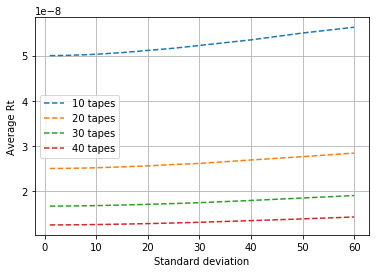

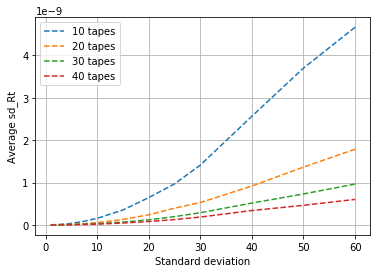

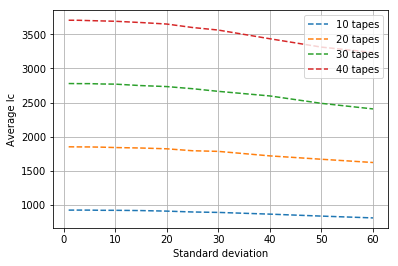

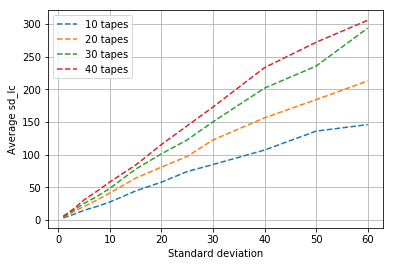

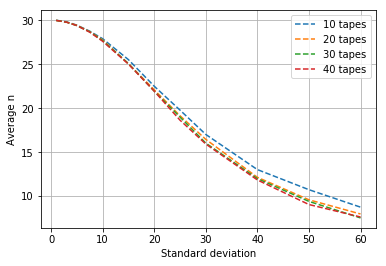

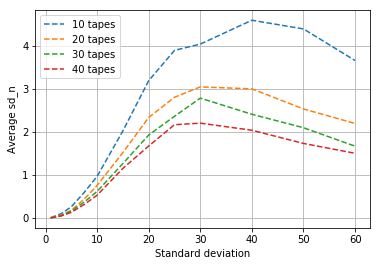

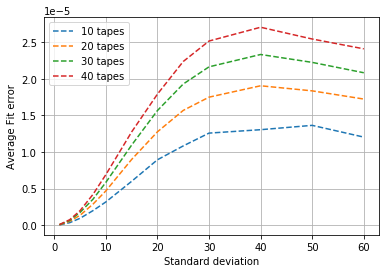

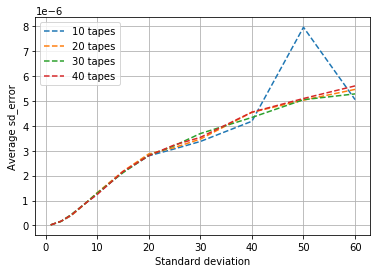

In [9]:
%matplotlib inline
#Nsamples = np.array([10])

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sigma = data[:,0]
    Ic_array = data[:,7]
    plt.plot(sigma,Ic_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average Rt')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Average Rt resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    Ic_array = data[:,8]
    plt.plot(sigma,Ic_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_Rt')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Average Ic resistive.png')
plt.show()


for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sigma = data[:,0]
    Ic_array = data[:,1]
    plt.plot(sigma,Ic_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average Ic')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Average Ic resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sd_Ic = data[:,2]
    plt.plot(sigma,sd_Ic,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_Ic')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Average sd_Ic resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    n_array = data[:,3]
    plt.plot(sigma,n_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average n')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Average n resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sd_n = data[:,4]
    plt.plot(sigma,sd_n,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_n')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Average sd_n resistive.png')
plt.show()    
    
for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    Error_fit_array = data[:,5]
    plt.plot(sigma,Error_fit_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average Fit error')
plt.xlabel('Standard deviation')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.savefig('Average Fit error resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sd_error = data[:,6]
    plt.plot(sigma,sd_error,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_error')
plt.xlabel('Standard deviation')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.savefig('Average sd_error resistive.png')
plt.show()
    #max_fiterror_index = data[:,7]
    #min_fiterror_index = data[:,8]

# Normalizing the results

For each array with averaged values, we divide x/x0 where x0 is the average value for the case with standard deviation of 1 A. 

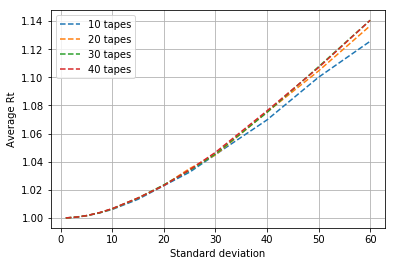

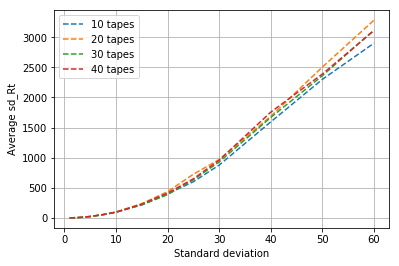

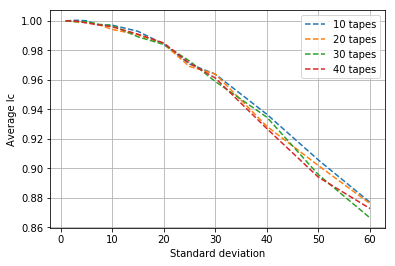

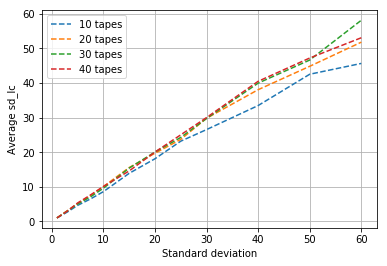

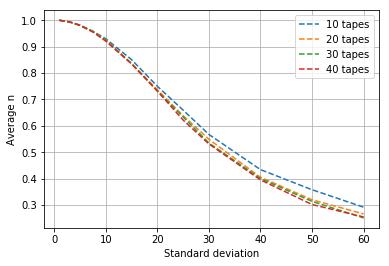

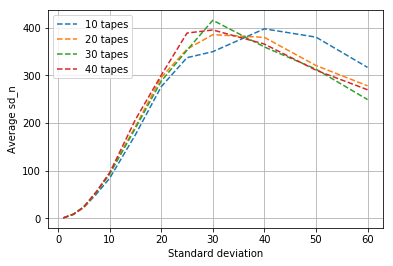

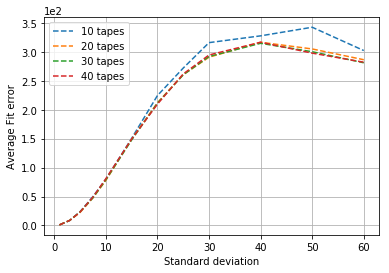

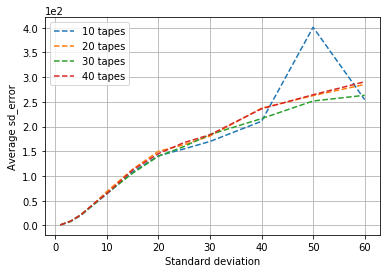

In [10]:
%matplotlib inline

#Nsamples = np.array([10])
for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sigma = data[:,0]
    Ic_array = data[:,7]/data[0,7]
    plt.plot(sigma,Ic_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average Rt')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Normalized Average Rt resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    Ic_array = data[:,8]/data[0,8]
    plt.plot(sigma,Ic_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_Rt')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Normalized Average Ic resistive.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    #print(data)
    sigma = data[:,0]
    Ic_array = data[:,1]/data[0,1]
    plt.plot(sigma,Ic_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average Ic')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Normalized Average Ic.png')
plt.show()  

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sd_Ic = data[:,2]/data[0,2]
    plt.plot(sigma,sd_Ic,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_Ic')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Normalized Average sd_Ic.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    n_array = data[:,3]/data[0,3]
    plt.plot(sigma,n_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average n')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Normalized Average n.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sd_n = data[:,4]/data[0,4]
    plt.plot(sigma,sd_n,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_n')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.savefig('Normalized Average sd_n.png')
plt.show()    
    
for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    Error_fit_array = data[:,5]/data[0,5]
    plt.plot(sigma,Error_fit_array,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average Fit error')
plt.xlabel('Standard deviation')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.savefig('Normalized Average Fit error.png')
plt.show()

for i in range(len(Ntapes)):
    data = readfilensample(Ntapes[i],Nsamples)
    sd_error = data[:,6]/data[0,6]
    plt.plot(sigma,sd_error,'--', label = f'{Ntapes[i]} tapes')
plt.ylabel('Average sd_error')
plt.xlabel('Standard deviation')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.savefig('Normalized Average sd_error.png')
plt.show()
    #max_fiterror_index = data[:,7]